In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# Read in individual datasets for each state
all_states = os.listdir('clean_data/')
all_states = {f[:2]:pd.read_csv(f"clean_data/{f}") for f in all_states if len(f)<7}
print("Total number of states (including Federal Bureau of Prisons):", len(all_states.keys()))
all_states['MA']

Total number of states (including Federal Bureau of Prisons): 51


,name,abbreviation,staff_tests,prisoner_tests,total_staff_cases,total_prisoner_cases,total_staff_deaths,total_prisoner_deaths,date,week_num
0,Massachusetts,MA,NaN,NaN,4.0,9.0,0.0,0.0,2020-03-26,2020-13
1,Massachusetts,MA,NaN,NaN,7.0,20.0,0.0,0.0,2020-04-01,2020-14
2,Massachusetts,MA,NaN,NaN,26.0,46.0,0.0,3.0,2020-04-08,2020-15
3,Massachusetts,MA,NaN,NaN,42.0,90.0,0.0,4.0,2020-04-15,2020-16
4,Massachusetts,MA,NaN,296.0,93.0,127.0,0.0,7.0,2020-04-22,2020-17
5,Massachusetts,MA,NaN,747.0,120.0,257.0,0.0,7.0,2020-04-29,2020-18
6,Massachusetts,MA,NaN,1906.0,151.0,351.0,0.0,7.0,2020-05-06,2020-19


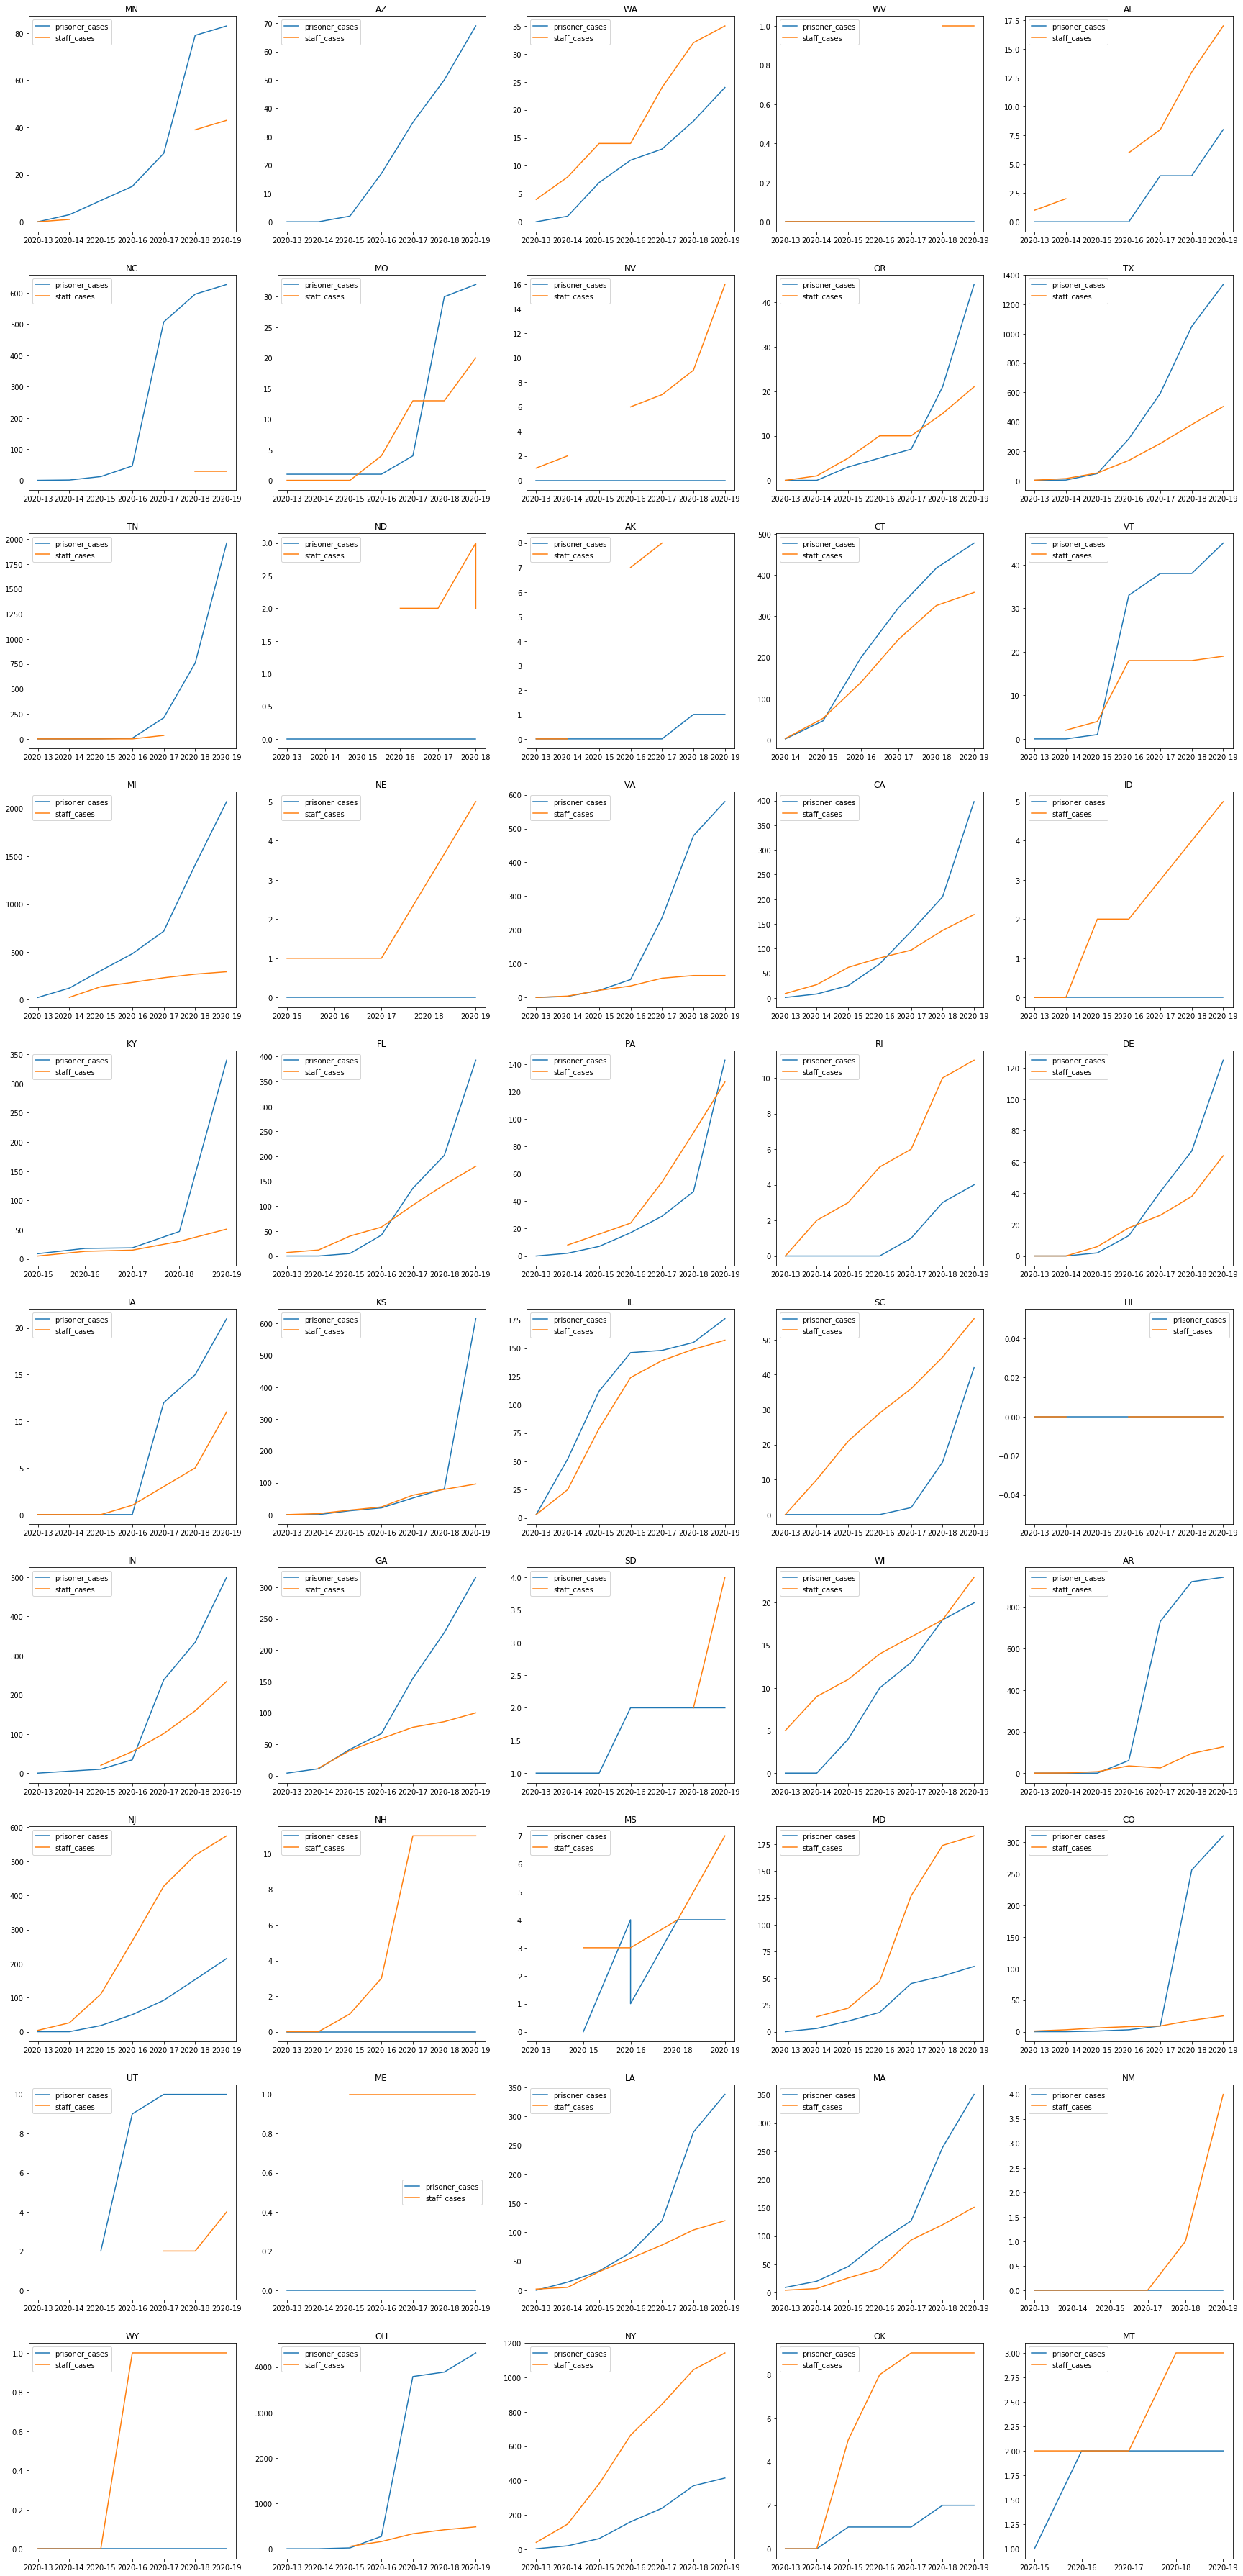

In [30]:
# Plot cumulative cases by state for staff and prisoners
state_names = [c for c in list(all_states.keys()) if 'US' not in c]

fg,axs = plt.subplots(10,5, figsize=(30,65))

for i, ax in enumerate(axs.ravel()):
    state = state_names[i]
    state_df = all_states[state]
    ax.plot(state_df['week_num'], state_df['total_prisoner_cases'], label = 'prisoner_cases')
    ax.plot(state_df['week_num'], state_df['total_staff_cases'], label = 'staff_cases')
    ax.legend()
    ax.set_title(f"{state}")

Text(0.5, 1.0, 'Cumulative cases for staff and prisoner within the U.S.')

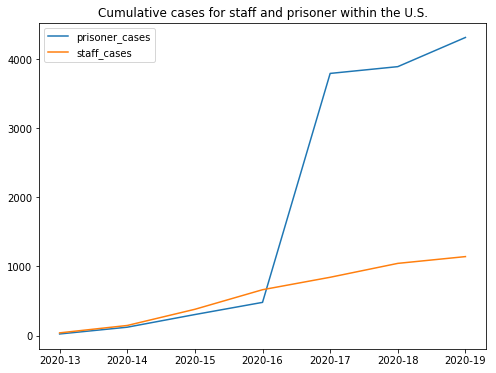

In [37]:
# Plot aggregrated cumulative cases for staff and prisoners
df = pd.read_csv('clean_data/covid_prison_cases.csv')
group_df = df.groupby('week_num')[['total_staff_cases', 'total_prisoner_cases']].max().reset_index()

plt.figure(figsize=(8,6))
plt.plot(group_df['week_num'], group_df['total_prisoner_cases'], label = 'prisoner_cases')
plt.plot(group_df['week_num'], group_df['total_staff_cases'], label = 'staff_cases')
plt.legend()
plt.title("Cumulative cases for staff and prisoner within the U.S.")

Text(0.5, 1.0, 'Cumulative cases for staff and prisoner within the U.S.')

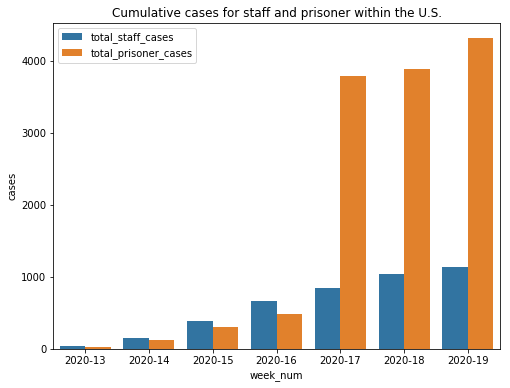

In [87]:
# Bar plot showing aggregrated cumulative cases for staff and prisoners
df = pd.read_csv('clean_data/covid_prison_cases.csv')
group_df = df.groupby('week_num')[['total_staff_cases', 'total_prisoner_cases']].max().reset_index()
melt_df = pd.melt(group_df, id_vars = 'week_num', var_name='type', value_name='cases')

plt.figure(figsize=(8,6))
sns.barplot(data = melt_df, x='week_num', y = 'cases', hue='type')
plt.legend()
plt.title("Cumulative cases for staff and prisoner within the U.S.")

# Adding in population data

In [73]:
pop = pd.read_csv('clean_data/population.csv')
print(pop.shape)
pop.head()

(51, 6)


,name,abbreviation,prison_pop,prison_pop_date,staff_pop,staff_pop_date
0,Alabama,AL,21154,1/31/2020,6259.0,9/30/2019
1,Alaska,AK,4997,12/31/2019,NaN,NaN
2,Arizona,AZ,41674,4/15/2020,8536.0,10/31/2019
3,Arkansas,AR,18181,2/29/2020,4045.0,2/29/2020
4,California,CA,118466,4/15/2020,46000.0,4/15/2020


In [74]:
pop.isna().sum()

name               0
abbreviation       0
prison_pop         0
prison_pop_date    0
staff_pop          6
staff_pop_date     6
dtype: int64

In [75]:
# Look at the states with NaN staff_pop
temp = pop[pop.staff_pop.isna()]
nan_states = temp['name']
temp

,name,abbreviation,prison_pop,prison_pop_date,staff_pop,staff_pop_date
1,Alaska,AK,4997,12/31/2019,NaN,NaN
10,Hawaii,HI,4631,3/31/2020,NaN,NaN
16,Kentucky,KY,11782,4/15/2020,NaN,NaN
19,Maryland,MD,18800,12/31/2019,NaN,NaN
25,Montana,MT,17355,6/30/2018,NaN,NaN
43,Utah,UT,6131,4/21/2020,NaN,NaN


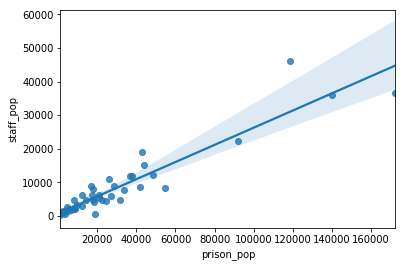

In [76]:
sns.regplot(pop['prison_pop'], pop['staff_pop'])

We will fill in the missing staff data with the assumption that there is a linear relationship between `staff_pop` and `prison_pop`.

In [77]:
# Fillin the nan values using a linear model
from sklearn.linear_model import LinearRegression
train = pop[pop['staff_pop']>0].copy()
test = pop[pop['staff_pop'].isna()].copy()
X_train, X_test, y_train = train[['prison_pop']], test[['prison_pop']], train['staff_pop']
ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)
y_pred = list(map(int, y_pred))

pop.loc[pop['staff_pop'].isnull(), 'staff_pop'] = y_pred
pop[pop['name'].isin(nan_states)]

,name,abbreviation,prison_pop,prison_pop_date,staff_pop,staff_pop_date
1,Alaska,AK,4997,12/31/2019,1971.0,NaN
10,Hawaii,HI,4631,3/31/2020,1878.0,NaN
16,Kentucky,KY,11782,4/15/2020,3706.0,NaN
19,Maryland,MD,18800,12/31/2019,5501.0,NaN
25,Montana,MT,17355,6/30/2018,5131.0,NaN
43,Utah,UT,6131,4/21/2020,2261.0,NaN


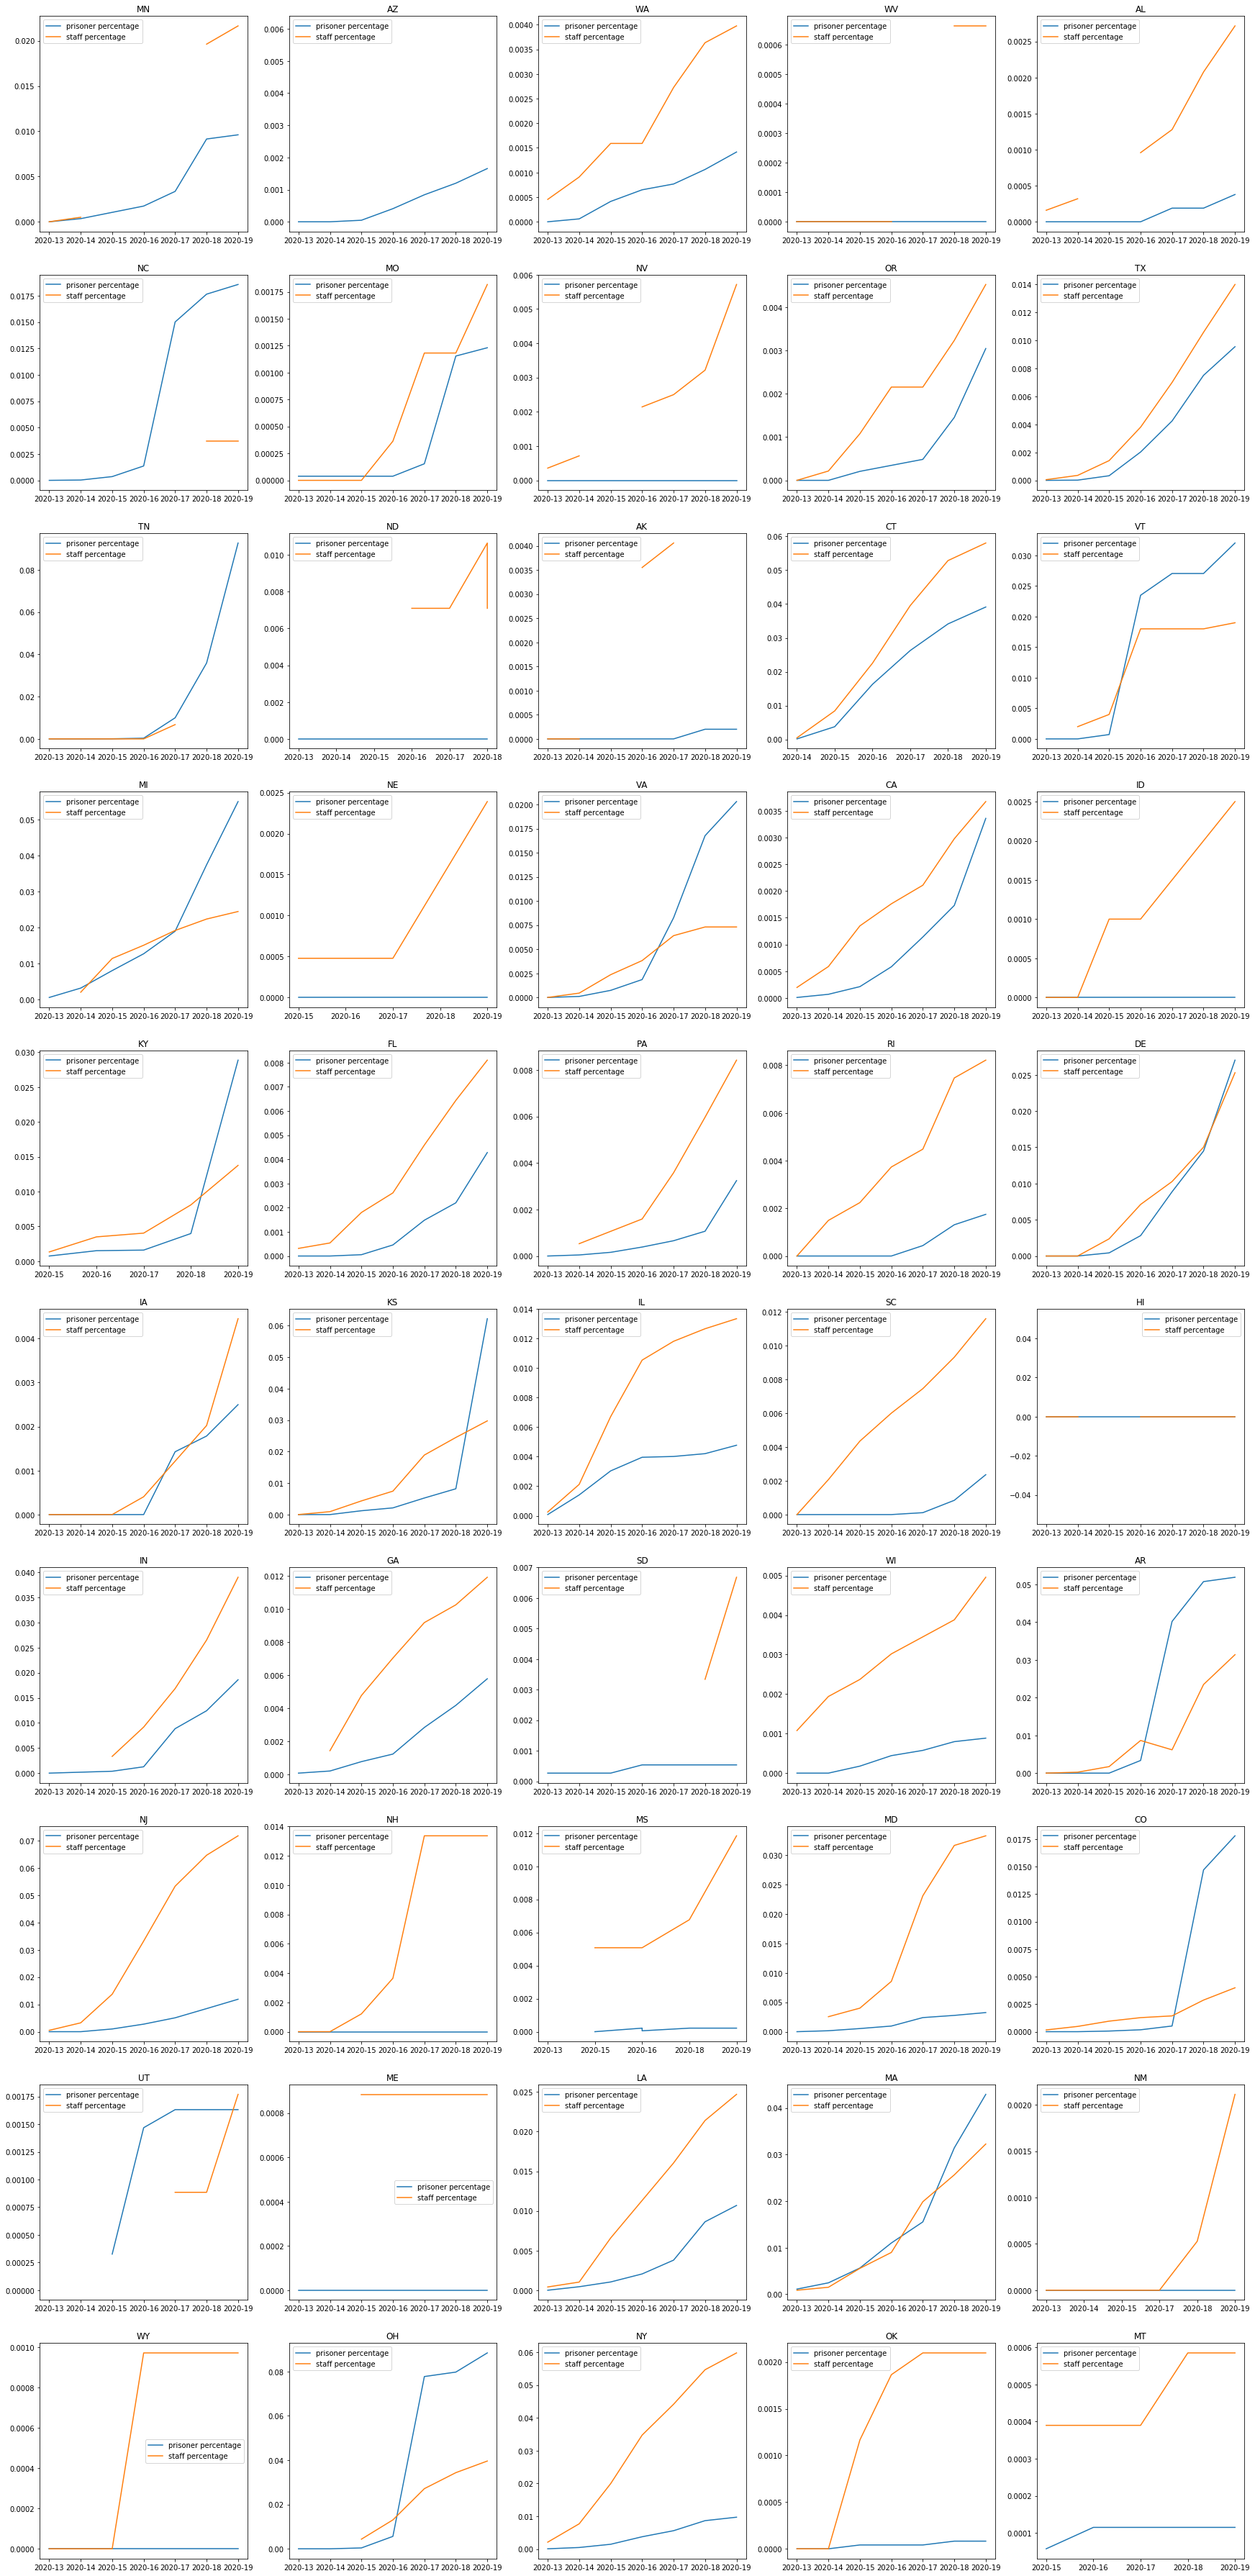

In [81]:
# Plot Percentage of cumulative cases by state for staff and prisoners
state_names = [c for c in list(all_states.keys()) if 'US' not in c]

fg,axs = plt.subplots(10,5, figsize=(30,65))

for i, ax in enumerate(axs.ravel()):
    state = state_names[i]
    state_df = all_states[state]
    prisoner_pop = pop[pop['abbreviation'] == state]['prison_pop'].values[0]
    staff_pop = pop[pop['abbreviation'] == state]['staff_pop'].values[0]
    ax.plot(state_df['week_num'], state_df['total_prisoner_cases']/prisoner_pop, label = 'prisoner percentage')
    ax.plot(state_df['week_num'], state_df['total_staff_cases']/staff_pop, label = 'staff percentage')
    ax.legend()
    ax.set_title(f"{state}")

Text(0.5, 1.0, 'Percentage of Cumulative cases for staff and prisoner within the U.S.')

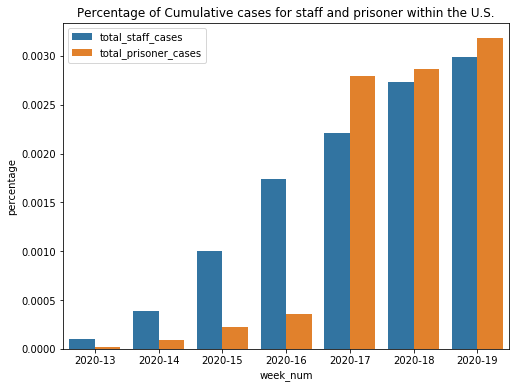

In [92]:
# Bar plot showing percentage of aggregrated cumulative cases for staff and prisoners
df = pd.read_csv('clean_data/covid_prison_cases.csv')
group_df = df.groupby('week_num')[['total_staff_cases', 'total_prisoner_cases']].max().reset_index()
group_df['total_staff_cases'] /= pop['staff_pop'].sum()
group_df['total_prisoner_cases'] /= pop['prison_pop'].sum()
melt_df = pd.melt(group_df, id_vars = 'week_num', var_name='type', value_name='percentage')
melt_df

plt.figure(figsize=(8,6))
sns.barplot(data = melt_df, x='week_num', y = 'percentage', hue='type')
plt.legend()
plt.title("Percentage of Cumulative cases for staff and prisoner within the U.S.")